#### Imports

In [1]:
import pandas as pd
from xgboost import DMatrix, train
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import seaborn as sns

### Load dataset and feature engineering


In [67]:
data = pd.read_csv('training_set_normalized_y.csv', sep = ";")
X_train = data.drop('y', axis=1)
y_train = data['y']


data_test = pd.read_csv('McrNet_testing_set_y.csv', sep = ";")
X_test = data_test.drop('y', axis=1)
y_test = data_test['y']

# Use the powertransformer to transform features and the target should be divided by the max value of the target
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer()
X_train = pt.fit_transform(X_train)
X_test = pt.transform(X_test)

y_train = y_train / y_train.max()
y_test = y_test / y_test.max()



# Train and predict

In [68]:


dtrain = DMatrix(X_train, label=y_train)
dtest = DMatrix(X_test, label=y_test)

deval = DMatrix(X_test, label=y_test)
evals_result = {} 

best_rmse = 10000000000
best_lr = 0.0
steps = np.arange(0.0, 0.5, 0.01)

'''
for lr in steps:
    params = {'objective':'reg:squarederror', 'learning_rate': lr}

    # Define evaluation data
    #eval_data = [(dtrain, 'train'), (deval, 'eval')]

    model = train(params, dtrain, num_boost_round=100)
    predictions = model.predict(dtest)

    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    if rmse < best_rmse:
        best_rmse = rmse
        best_lr = lr
print("Best MSE: " + str(best_rmse))
print("Best LR: " + str(best_lr))
'''

params = {'objective':'reg:squarederror', 'learning_rate': 0.32}
num_round = 100000
# Define evaluation data
#eval_data = [(dtrain, 'train'), (deval, 'eval')]

model = train(params, dtrain, num_boost_round=num_round, evals=[(dtrain, 'train'), (dtest, 'test')], evals_result=evals_result, verbose_eval=False)

predictions = model.predict(dtest)



## Evaluate

In [69]:
from sklearn.metrics import r2_score

print("Testing")
# Calculate MAE
mae = mean_absolute_error(y_test, predictions)
print('Mean Absolute Error:', mae)

# Calculate MSE
mse = mean_squared_error(y_test, predictions)
print('Mean Squared Error:', mse)

# Calculate RMSE
rmse = mean_squared_error(y_test, predictions, squared=False)
print('Root Mean Squared Error:', rmse)



# Calculate the error
dtest = DMatrix(X_test, label=y_test)

error = model.eval(dtest)
print('Evaluation Error:', error)


# Calculate R-squared
r2 = r2_score(y_test, predictions)
print('R-squared:', r2)

model = train(params, dtrain, num_boost_round=100)
predictions_training = model.predict(dtrain)

print("Training")
# Calculate MAE
mae2 = mean_absolute_error(y_train, predictions_training)
print('Mean Absolute Error:', mae2)

# Calculate MSE
mse2 = mean_squared_error(y_train, predictions_training)
print('Mean Squared Error:', mse2)

# Calculate RMSE
rmse2 = mean_squared_error(y_train, predictions_training, squared=False)
print('Root Mean Squared Error:', rmse2)



# Calculate the error
dtrain = DMatrix(X_train, label=y_train)

error2 = model.eval(dtrain)
print('Evaluation Error:', error2)


# Calculate R-squared
r22 = r2_score(y_train, predictions_training)
print('R-squared:', r22)




Testing
Mean Absolute Error: 0.015277226768520122
Mean Squared Error: 0.000511818240457361
Root Mean Squared Error: 0.02262340028504471
Evaluation Error: [0]	eval-rmse:0.02262340030661063
R-squared: 0.9633272861212911
Training
Mean Absolute Error: 0.010797634120923246
Mean Squared Error: 0.00028385290448420435
Root Mean Squared Error: 0.016847934724594713
Evaluation Error: [0]	eval-rmse:0.01684793471461809
R-squared: 0.9758410372687867


# Plotting

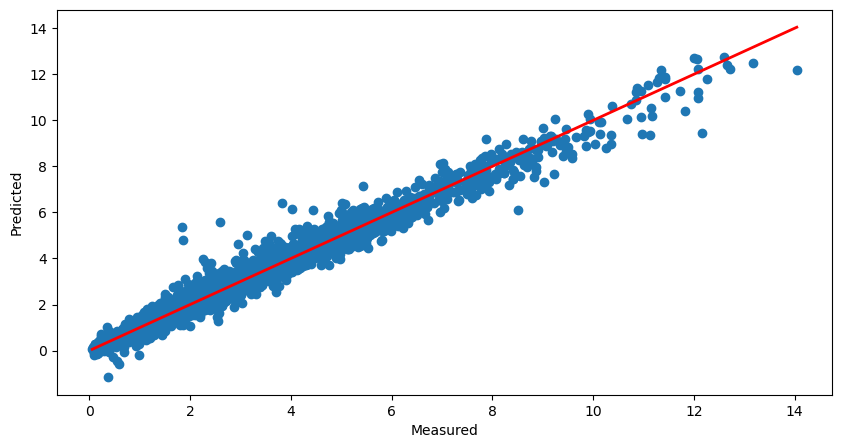

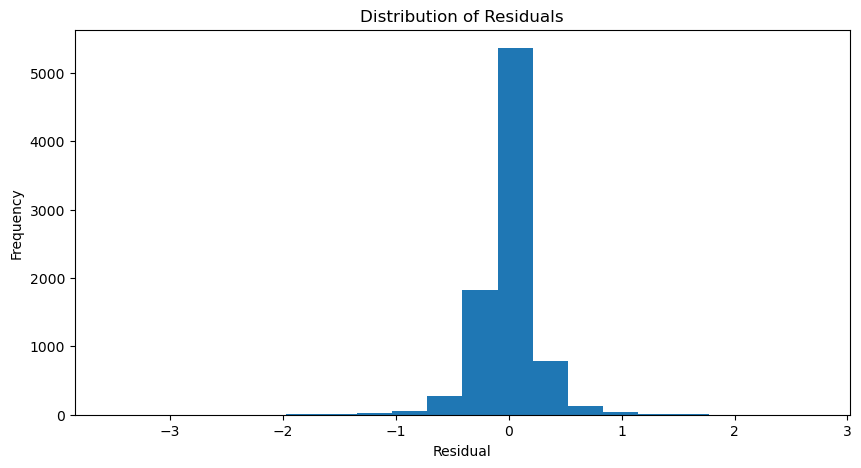

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(y_test, predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.show()

residuals = y_test - predictions

plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=20)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

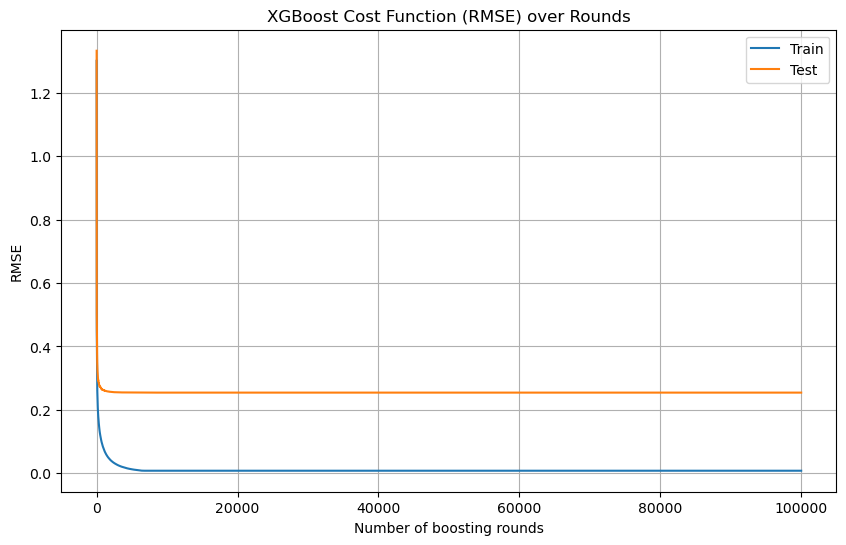

In [64]:
# Plotting the cost function (evaluation metric) over boosting rounds
train_metric = evals_result['train']['rmse']
test_metric = evals_result['test']['rmse']
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_round+1), train_metric, label='Train')
plt.plot(range(1, num_round+1), test_metric, label='Test')
plt.xlabel('Number of boosting rounds')
plt.ylabel('RMSE')
plt.title('XGBoost Cost Function (RMSE) over Rounds')
plt.legend()
plt.grid()
plt.show()